In [1]:
import lightkurve as lk
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [15]:
from scipy import signal, ndimage
from astropy.modeling import models, fitting

In [ ]:
#tpf = lk.search_tesscut('V* W Cet').download(cutout_size=50)

In [ ]:
tpf = lk.open('/Users/ch/.lightkurve-cache/tesscut/tess-s0002-1-3_0.530800_-14.675530_50x50_astrocut.fits')

In [ ]:
tpf = lk.open('/Users/ch/.lightkurve-cache/tesscut/tess-s0015-2-3_301.564386_44.456886_30x30_astrocut.fits')

In [ ]:
tpf.show_properties()

In [3]:
from astropy.io import fits
hdu = fits.open('https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018235205941-s0002-1-3-0121-s_ffic.fits')

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


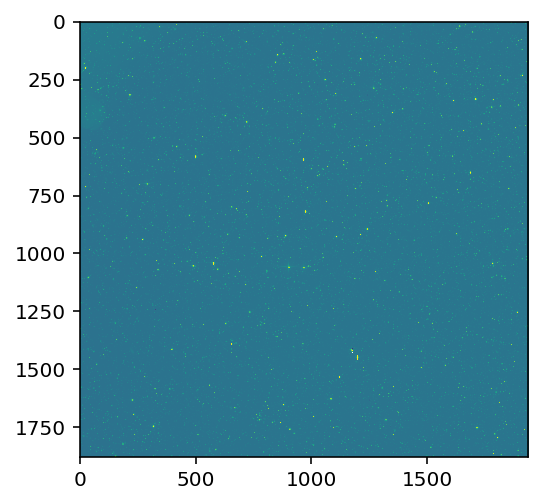

In [5]:
#plt.figure(figsize=(40, 40))
plt.imshow(np.log10(hdu[1].data[100:-100, 100:-100]))

In [14]:
im = hdu[1].data[100:-100, 100:-100]

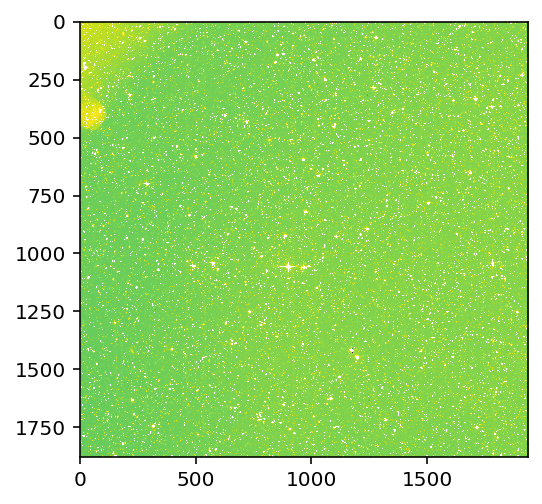

In [22]:
bkg = np.copy(im)
bkg[im > 200] = np.nan
plt.imshow(bkg)

In [26]:
mf = ndimage.median_filter(im, size=51)

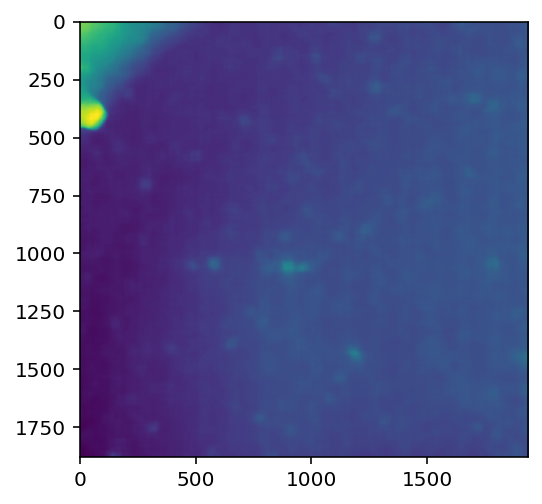

In [27]:
plt.imshow(mf)

In [13]:
# aper = tpf.create_threshold_mask()
# pixels = tpf.flux[:, np.ones(tpf.flux.shape[1:], bool)]
# pixel_err = tpf.flux_err[:, np.ones(tpf.flux.shape[1:], bool)]

In [6]:
nc = 10
cross = np.zeros((nc + 1, nc + 1))
cross[nc//2 + -nc//2:nc//2 + nc//2 + 1, nc//2] = 1
cross[nc//2, nc//2 + -nc//2:nc//2 +  nc//2 + 1] = 1

In [7]:
# Y, X = np.meshgrid(np.arange(tpf.shape[1]) - tpf.shape[1]/2, np.arange(tpf.shape[2]) - tpf.shape[2]/2)
# X = (np.atleast_3d(X).T * np.ones(tpf.flux.shape)).ravel()
# Y = (np.atleast_3d(Y).T * np.ones(tpf.flux.shape)).ravel()
# T = (np.atleast_3d(tpf.time - tpf.time.mean()).transpose([1, 0, 2]) * np.ones(tpf.flux.shape)).ravel()
# matrix = np.vstack([np.ones(len(X)), X, Y, X*Y, X**2, Y**2, X**2*Y, Y**2*X, X**2*Y**2]).T

In [8]:
# dm_background = lk.DesignMatrix(matrix)

In [9]:
# r = lk.correctors.RegressionCorrector(lk.LightCurve(T, tpf.flux.ravel()))

In [10]:
# r.correct(dm_background)

In [11]:
# bkg = r.model_lc.flux.reshape(tpf.flux.shape)
# bkg -= np.percentile(bkg, 5)

In [ ]:
Y, X = np.mgrid[:im.shape[0], :im.shape[1]]
X, Y = X.ravel(), Y.ravel()


In [ ]:
matrix = np.vstack([X, Y, np.ones(len(Y)), X**2, Y**2, X*Y, X**2*Y, Y**2*X])

In [ ]:
mask = im.ravel() < 200
A = np.dot(matrix[:, mask].T, matrix[:, mask])
B = np.dot(matrix[:, mask].T, im.ravel()[mask])

In [ ]:
npoints = 20
fb = [np.nanpercentile(im, idx) for idx in np.linspace(0, 100, npoints)]
fb = np.append(im.min(), fb)
im_c = np.zeros((npoints - 1, im.shape[0], im.shape[1]), float)
for idx, a, b in zip(np.arange(npoints), fb[1:-1], fb[2:]):
    im_m = np.asarray(((im > a) & (im < b)), float)
    im_c[idx, :, :] = np.asarray(signal.convolve(im_m, cross, 'same'), float)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(im, vmin=0, vmax=5)
plt.colorbar()

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(np.max(im_c, axis=0) - np.min(im_c, axis=0))
plt.colorbar()